 # Dr. Kativa Agarwal RNA-seq analysis of VK2 cells


# RNASeq Differential Expression Testing and Visualization

* Daisy Chilin-Fuentes, CCBB (dchilinfuentes@ucsd.edu)
* Based on upstream analysis by Daisy Chilin-Fuentes, CCBB (dchilinfuentes@ucsd.edu)


* Modeled on "RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR" ([1](#Citations))

## Table of Contents
* [Introduction](#Introduction)
* [Parameter Input](#Parameter-Input)
* [Library Import](#Library-Import)
* [Differential Expression Testing](#Differential-Expression-Testing)
    * [Design Model Creation](#Design-Model-Creation)
    * [Contrast Creation](#Contrast-Creation)
    * [Removal of Heteroscedascity](#Removal-of-Heteroscedascity)
    * [Discussion of Statistical Treatment of Replicates](#Discussion-of-Statistical-Treatment-of-Replicates)
    * [Fitting of Linear Models](#Fitting-of-Linear-Models)
    * [Summarization of Differentially Expressed Genes](#Summarization-of-Differentially-Expressed-Genes)


* [Examination of Individual Comparisons](#Examination-of-Individual-Comparisons)

    * [NanH2 treated at 2 hrs vs NanH2 treated at 1 hr](#NanH2-treated-at-2-hrs-vs-NanH2-treated-at-1-hr)
    * [NanH2 treated at 2 hrs vs Vector Ctrl treated at 2hrs](#NanH2-treated-at-2-hrs-vs-Vector-Ctrl-treated-at-2hrs)
    * [Vector Ctrl treated at 2hrs vs NanH2 treated at 1 hr](#Vector-Ctrl-treated-at-2hrs-vs-NanH2-treated-at-1-hr)
   

* [Summary](#Summary)
* [Citations](#Citations)
* [Appendix: R Session Info](#Appendix:-R-Session-Info)


## Introduction

This notebook takes in RNASeq data prepared by the previous notebook, "3_RNASeq_Data_Exploration_and_Preprocessing", and uses the limma ([2](#Citations)) and edgeR ([3](#Citations)) Bioconductor ([4](#Citations)) packages written in R ([5](#Citations)) to test for differential expression in comparisons of interest to the researcher using the voom technique ([6](#Citations)).

[Table of Contents](#Table-of-Contents)

## Parameter Input

In [1]:
gPreviousStepRdataFp =  "../interim/20230302162901_data_exploration.RData"

In [2]:
# Import shared source code to load and save previous notebooks' environments:
gSourceDir = "./src/"
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state and load relevant variables:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [3]:
# Load relevant variables:
gProjectName = gPreviousStepEnv$gProjectName
gInterimDir = gPreviousStepEnv$gInterimDir
gOutputDir = gPreviousStepEnv$gOutputDir
gNormedFilteredDgeList = gPreviousStepEnv$gNormedFilteredDgeList
gGeneIdCol = gPreviousStepEnv$gGeneIdCol

gOutputDir_nb3 <- paste0(gOutputDir, "/differential_expression")
dir.create(gOutputDir_nb3)
gOutputDir_nb3

Warning message in dir.create(gOutputDir_nb3):
“'../secondary_analysis_results/differential_expression' already exists”


[1] "../secondary_analysis_results/differential_expression"

Populate the run name parameter automatically to ensure that outputs from different runs do not overwrite each other:

In [4]:
gRunName = format(Sys.time(), "%Y%m%d%H%M%S")
gRunName

[1] "20230307084317"

In [5]:
# Create subdirectory with timestamp to keep multiple iterations separated
gOutputDir_nb3 <- paste0(gOutputDir_nb3, "/", gRunName)
dir.create(gOutputDir_nb3) 
gOutputDir_nb3

[1] "../secondary_analysis_results/differential_expression/20230307084317"

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [ ]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

In [ ]:
#BiocManager::install("limma", version = "3.8")

In [ ]:
#BiocManager::install("Glimma", version = "3.8")

In [ ]:
#install.packages("gdata")

In [ ]:
#install.packages("cowplot")

In [ ]:
#install.packages("gplots")

In [ ]:
#install.packages("statmod")

In [ ]:
#BiocManager::install("RNASeqPower", version = "3.8")

In [ ]:
#install.packages("RColorBrewer")

In [6]:
library(limma)
library(edgeR)
library(Glimma)
library(statmod)

In [7]:
library(IRdisplay)
library(RColorBrewer)

In [8]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))

In [9]:
# This cell supports future resizing of the plots in the Jupyter notebook
gDefaultWidth = getOption("repr.plot.width")
gDefaultHeight = getOption("repr.plot.height")
resetPlotSize = function(){
    options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight)
}

In [10]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

[Table of Contents](#Table-of-Contents)

## Differential Expression Testing

Conceptually, determining differential expression for a given gene between conditions of interest in experimental data is a simple matter of looking at the measured expression levels for that gene in each condition of interest and determining if they are different from each other.  For example, in case A in the plot below, the gene expression in the treated condition is clearly lower than that in the control condition:

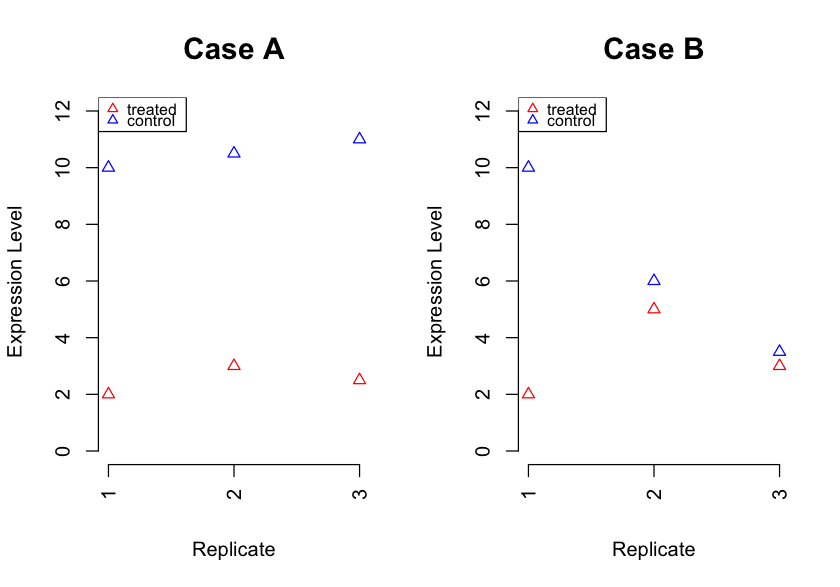

In [11]:
drawExamplePlots = function(){
    par(mfrow=c(1,2))
    
    replicate <- 1:3
    dat <- data.frame(
      x = rep(replicate,2),
      y = c(2, 3, 2.5, 10, 10.5, 11),
      treatment = c(rep("treated",3), rep("control",3))
    )
    
    drawExamplePlot(dat, "Case A")
    
    dat$y = c(2, 5, 3, 10, 6, 3.5)
    drawExamplePlot(dat, "Case B")
}

drawExamplePlot = function(dat, case){
    plot(dat$x, dat$y, xaxt="n",
         xlab="Replicate", ylab="Expression Level", 
         xlim=c(1,3), ylim=c(0,12), 
         main=case, pch=2, 
         cex.main=1.5, frame.plot=FALSE, 
         col=ifelse(dat$treatment=="treated", "red", "blue"))
    
    legend("topleft", pch=c(2,2), col=c("red", "blue"), c("treated", "control"), bty="o",  cex=.8)
    axis(1, xaxp=c(1,3,2), las=2)
}

#resize the output for attractive side-by-side plots
options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight*.7) 
drawExamplePlots()
options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight) 

However, in reality, data often look less clear-cut, like those shown in case B; therefore, instead of examining the data qualitatively, analysts apply a statistical test that integrates replicate data to calculate the degree of difference in expression level and determine if that difference is statistically significant.  In a simple experiment like that shown above, one could accomplish this with a Student's t-test, but real studies usually have a more complex experimental design.  This design may include multiple levels of a condition of interest (e.g., several different treatments), multiple factors of interest (e.g., both treatment and disease state), repeated measurements over time on the same subject, and/or batch effects or confounding variables that must be accounted for (e.g., subject age, sex, etc).  Therefore, a common technique is to use statistical tests based on linear models, which are able to appropriately estimate amount and significance of differential expression for such complex experiments (as well as for very simple ones).


### Background on Linear Models

The limma package performs differential expression testing using linear models, especially the subset of these known as simple linear regression models.  In this context, a model is simply a formula predicting a variable of interest based on some known other variables, and linear regression is the process by which we arrive at this model:

> [Simple l]inear regression is used to predict the value of a continuous variable Y based on one or more input predictor variables X. The aim is to establish a mathematical formula between the the response variable (Y) and the predictor variables (Xs). You can use this formula to predict Y, when only X values are known. ([7](#Citations))

Y is also sometimes referred to as dependent variable or the observation, and the Xs are also called independent variables. The basic format of the mathematical formula of a linear model is 

Y = B<sub>0</sub> + B<sub>1</sub>\*X<sub>1</sub> + B<sub>2</sub>\*X<sub>2</sub> + ... + B<sub>n</sub>\*X<sub>n</sub> + e

where X<sub>1 through n</sub> are the independent variables and B<sub>1 through n</sub> are their coefficients, B<sub>0</sub> is the intercept, and e is a random error.  

In the context of differential expression testing, we attempt to predict a particular gene's expression level (the independent variable Y) in a particular sample based on independent variables X from the metadata about that sample such as treatment applied, time point at which expression was assessed, sex of subject, etc. (Non-numeric independent variables are easily accommodated in this approach using "dummy variables"; see [https://en.wikipedia.org/wiki/Dummy_variable_(statistics)](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) for details).  While the formula format shown above gives the basic idea, there are in fact multiple ways to represent the independent variables in the formula (see [Design Model Creation](#Design-Model-Creation) below), and the data analyst must decide on the most appropriate format of the formula for the hypotheses being tested in a particular experiment.  
    
Once the formula format has been specified, the linear regression process takes in training data cases (where each case is a known Y value with its associated X values) and decides upon (or "fits") numeric values to the coefficients B<sub>1 through n</sub> in the formula format.  The goal is to find B<sub>1 through n</sub> values such that when one plugs the known X values for each training data case into the formula, one gets a Y value that is the same as (or at least close to!) the real Y value known from the training data.  Usually this fitting is done by least squares approximation; see [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares) for further details on this process.

In differential expression analysis, the experimental data are used as the training cases: the observations of a given gene's read counts in the experimental samples are the Y values, while the metadata for each sample are the X values. limma fits one linear model for EACH gene; all models share the same formula *format* but each has its own gene-specific *coefficients*, one for each independent variable; each of these coefficients also has an estimate of its standard deviation. 

To determine whether a particular independent variable affects the expression level of a given gene, it is simply necessary to perform a t-test to determine whether the coefficient for that variable is statistically significantly different from zero.  limma performs this test based on a "moderated" t-statistic:

> This has the same interpretation as an ordinary t-statistic except that the standard errors have been
moderated across genes, i.e., squeezed towards a common value, using a simple Bayesian model.
This has the effect of borrowing information from the ensemble of genes to aid with inference about
each individual gene[.] ([8](#Citations))

The coefficients can, if necessary, be processed into "contrasts" (see [Contrast Creation](#Contrast-Creation) below) to that can be similarly tested to see if they differ from zero in order to address questions about, for example, whether two conditions affect a gene's expression *differently*.

### Design Model Creation

The formula format used in the linear model fitting is specified by a design model.  In limma, this is represented as a matrix in which each row is a sample in the experiment and each column is a representation of a dependent variable; due to the use of dummy variables, one dependent variable may be represented by more than one column.

In [12]:
generateGroupMeansDesignModel = function(designDf){

    design_levels = mapply(paste0, "", 
            designDf[["Condition_Time"]], USE.NAMES=FALSE)
        unique_levels = unique(design_levels)
        f = factor(design_levels, levels=unique_levels)
        designModel = model.matrix(~0+f)
        rownames(designModel) = designDf[["Sample.Name"]] # or potentially rownames(designDf)
        colnames(designModel) = unique_levels

        return(designModel)
    }

In [13]:
gDesignModel = generateGroupMeansDesignModel(gNormedFilteredDgeList$samples)
gDesignModel

,NanH2_treated_2H,NanH2_treated_1H,Vector_treated_2H
VK2_NanH2_PolyB25_2h_1,1,0,0
VK2_NanH2_PolyB25_2h_2,1,0,0
VK2_NanH2_PolyB25_2h_3,1,0,0
VK2_NanH2_PolyB25_2h_4,1,0,0
VK2_NanH2_PolyB25_1h_5,0,1,0
VK2_NanH2_PolyB25_1h_6,0,1,0
VK2_NanH2_PolyB25_1h_7,0,1,0
VK2_NanH2_PolyB25_1h_8,0,1,0
VK2_Pet28a_PolyB25_2h_9,0,0,1
VK2_Pet28a_PolyB25_2h_10,0,0,1


[Table of Contents](#Table-of-Contents)

### Contrast Creation

Depending on how the design model is defined, its terms may not always directly address the group comparisons of interest.  Therefore, it is possible to define "contrasts", or differences of terms.  Contrasts allow you to "take the initial coefficients and compare them in as many ways as you want to answer any questions you might have,
regardless of how many or how few these might be." ([8](#Citations))

In [14]:
gContrastMatrix = makeContrasts(
    
    NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs=NanH2_treated_2H - NanH2_treated_1H,
    NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs=NanH2_treated_2H - Vector_treated_2H,
    NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs= NanH2_treated_1H - Vector_treated_2H,


        
    levels=colnames(gDesignModel))

In [15]:
gContrastMatrix

,NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs,NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs,NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
NanH2_treated_2H,1,1,0
NanH2_treated_1H,-1,0,1
Vector_treated_2H,0,-1,-1


[Table of Contents](#Table-of-Contents)

### Removal of Heteroscedascity

Heteroscedacity "refers to the circumstance in which the variability of a variable is unequal across the range of values of a second variable that predicts it" ([9](#Citations)).

> It has been shown that for RNA-seq count data, the variance is not independent of the mean (Law et al. 2014) – this is true of raw counts or when transformed to log-CPM values. Methods that model counts using a Negative Binomial distribution assume a quadratic mean-variance relationship. In limma, linear modelling is carried out on the log-CPM values which are assumed to be normally distributed and the mean-variance relationship is accommodated using precision weights calculated by the voom function.
>
> When operating on a DGEList-object, voom converts raw counts to log-CPM values by automatically extracting library sizes and normalisation factors from x itself. Additional normalisation to log-CPM values can be specified within voom using the normalize.method argument.
>
> The mean-variance relationship of log-CPM values for this dataset is shown in ... the next figure. Typically, the voom-plot shows a decreasing trend between the means and variances resulting from a combination of technical variation in the sequencing experiment and biological variation amongst the replicate samples from different cell populations. Experiments with high biological variation usually result in flatter trends, where variance values plateau at high expression values. Experiments with low biological variation tend to result in sharp decreasing trends.
>
> Moreover, the voom-plot provides a visual check on the level of filtering performed upstream. If filtering of lowly-expressed genes is insufficient, a drop in variance levels can be observed at the low end of the expression scale due to very small counts. If this is observed, one should return to the earlier filtering step and increase the expression threshold applied to the dataset.
>
> Where sample-level variation is evident from earlier inspections of the MDS plot, the voomWithQualityWeights function can be used to simultaneously incorporate sample-level weights together with the abundance dependent weights estimated by voom (Liu et al. 2015). For an example of this, see Liu et al. (2016) (Liu et al. 2016). ([1](#Citations))

Apply the voom method to model the mean-variance relationship in the log-CPM values.

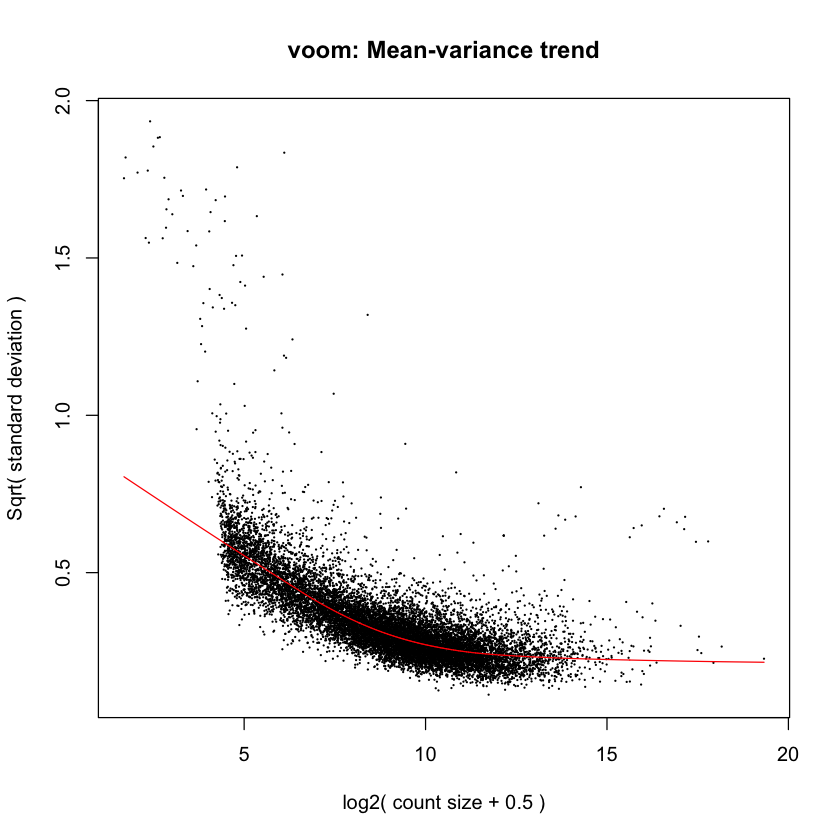

In [16]:
gInitialVoomResult = voom(gNormedFilteredDgeList, gDesignModel, plot=TRUE)

In [17]:
gVoomResult = gInitialVoomResult

[Table of Contents](#Table-of-Contents)

### Fitting of Linear Models

Fit a separate linear model to the expression values of each gene, and apply empirical Bayes moderation to improve the estimates of gene-wise variability by borrowing information across genes.

In [18]:
gVoomedFit = lmFit(gVoomResult, gDesignModel)

In [19]:
gVoomedFitForContrasts = contrasts.fit(gVoomedFit, contrasts=gContrastMatrix)

In [20]:
gModeratedVoomedFitForContrasts = eBayes(gVoomedFitForContrasts)

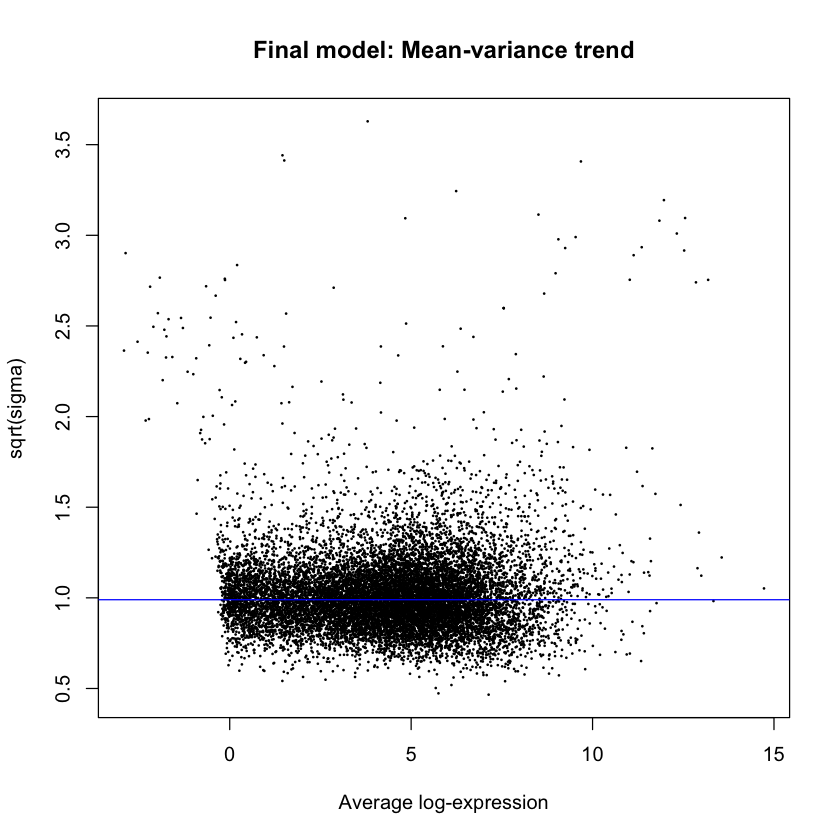

In [21]:
plotSA(gModeratedVoomedFitForContrasts, main="Final model: Mean-variance trend")

The above graphic demonstrates that the mean-variance relationship shown earlier in the voom plot has been removed by the use of the voom-produced weights.


While the voom analysis above accounts for the fact that variance is not independent of the mean, for the purposes of later per-comparison power analysis, estimate a common dispersion across all genes and an associated biological coefficient of variation (BCV). 

In the context of RNASeq, global variance is defined as the sum of technical and biological variance. Technical variance can be decreased by increasing sequencing depth. However, the impact of sequencing depth on global variance is limited by the amplitude of the biological variation. In other words, at a certain point, deeper sequencing doesn't provide additional value. In these situations, it becomes more useful to add additional samples. The RNASeqPower R package calculates a formal sample size comparison for two groups involving the following 5 factors:
    
    1. The depth of sequencing and consequent expected count for a given transcript;
    2. The coefficient of variation of counts within each of the 2 groups;
    3. The size difference (fold-change) that we wish to detect;
    4. The target false positive rate and false negative rate (or power);
    5. The number of samples in each group.
    
([12](#Citations))

In [22]:
gCommonDispersion <- estimateGLMCommonDisp(gNormedFilteredDgeList, gDesignModel, 
                                           verbose=TRUE)
# The biological coefficient of variation is the square root of the common dispersion
gBcv = sqrt(gCommonDispersion$common.dispersion)

Disp = 0.00329 , BCV = 0.0574 


[Table of Contents](#Table-of-Contents)

### Summarization of Differentially Expressed Genes

Look at the summary information on how many differentially expressed genes, in which directions, are found for each comparison.  By default, differentially expressed genes are identified as those with a Benjamini-Hochberg-adjusted p-value of <= 0.05.

Note that the Benjamini-Hochberg adjustment ([13](#Citations)) addresses correcting p-values across multiple tested genes, not across multiple tested contrasts:

>If several contrasts are being tested simultaneously, then the issue arises of multiple
testing for the entire set of hypotheses being considered, across contrasts as well as probes. The
function decideTests() offers a number of strategies for doing this.
The simplest multiple testing method is method="separate". This method does multiple testing
for each contrast separately. This method is the default because it is equivalent to using topTable().
Using this method, testing a set of contrasts together will give the same results as when each contrast
is tested on its own. The great advantage of this method is that it gives the same results regardless
of which set of contrasts are tested together. The disadvantage of this method is that it does not
do any multiple testing adjustment between contrasts. Another disadvantage is that the raw p-value
cutoff corresponding to significance can be very different for different contrasts, depending on the
number of DE probes. This method is recommended when different contrasts are being analysed to
answer more or less independent questions.
>
> method="global" is recommended when a set of closely related contrasts are being tested. This
method simply appends all the tests together into one long vector of tests, i.e., it treats all the tests
as equivalent regardless of which probe or contrast they relate to. An advantage is that the raw
p-value cutoff is consistent across all contrasts. For this reason, method="global" is recommended if
you want to compare the number of DE genes found for different contrasts, for example interpreting
the number of DE genes as representing the strength of the contrast. However users need to be aware
that the number of DE genes for any particular contrasts will depend on which other contrasts are
tested at the same time. Hence one should include only those contrasts which are closely related to
the question at hand. Unnecessary contrasts should be excluded as these would affect the results for
the contrasts of interest. Another more theoretical issue is that there is no theorem which proves that
adjust.method="BH" in combination with method="global" will correctly control the false discovery
rate for combinations of negatively correlated contrasts, however simulations, experience and some
theory suggest that the method is safe in practice. ([8](#Citations))

In [23]:
gMultipleTestingStrategy = "separate"

In [24]:
summary(decideTests(gModeratedVoomedFitForContrasts, method=gMultipleTestingStrategy))

       NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs
Down                                       15
NotSig                                  13810
Up                                         10
       NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs
Down                                            0
NotSig                                      13833
Up                                              2
       NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
Down                                           3
NotSig                                     13809
Up                                            23

In [25]:
summary(decideTests(gModeratedVoomedFitForContrasts, method=gMultipleTestingStrategy, p.value = 0.1))

       NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs
Down                                       34
NotSig                                  13777
Up                                         24
       NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs
Down                                            0
NotSig                                      13833
Up                                              2
       NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
Down                                           7
NotSig                                     13779
Up                                            49

In [26]:
summary(decideTests(gModeratedVoomedFitForContrasts, method=gMultipleTestingStrategy, p.value = 0.2))

       NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs
Down                                      149
NotSig                                  13536
Up                                        150
       NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs
Down                                            1
NotSig                                      13832
Up                                              2
       NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
Down                                          21
NotSig                                     13734
Up                                            80

In [27]:
summary(decideTests(gModeratedVoomedFitForContrasts, method=gMultipleTestingStrategy, p.value = 0.3))

       NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs
Down                                      472
NotSig                                  12914
Up                                        449
       NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs
Down                                            1
NotSig                                      13832
Up                                              2
       NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
Down                                         150
NotSig                                     13434
Up                                           251

Because researchers often wish to receive differential expression results limited to those genes with absolute fold-changes >= some threshold, we use the TREAT approach ([14](#Citations)), which "[i]nstead of testing for genes which have log-fold-changes different from zero, ... tests whether the log2-fold-change is greater than lfc in absolute value" ([15](#Citations)).  The log-fold-change testing is therefore incorporated into the p-value calculation.  For example, if one wishes to find only those genes with fold change >=2 or <= -2 (i.e, those with  absolute fold-change of 2, and thus log2 fold-change of 1) rather than applying two thresholds (adjusted p-value that absolute log-fold-change is different than zero is <= 0.05, and absolute log-fold-change is >= 2), one instead applys a single threshold (adjusted p-value that absolute log-fold-change is >=2 is <= 0.05).  If the log-fold-change threshold is set to zero, then then results of the TREAT method are equivalent to simply identify genes whose adjusted p-value that absolute log-fold-change is different than zero is <= 0.05.

In [28]:
gLog2AbsFcThreshold = 0
gThresholdDescription = "DiffExpFdrLte0.05"

In [29]:
gModeratedVoomedFitForContrastsWithLogFcThreshold = treat(gModeratedVoomedFitForContrasts, 
                                                          lfc=gLog2AbsFcThreshold)

In [30]:
gLogThresholdedTestResults = decideTests(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
                                         method=gMultipleTestingStrategy)

In [31]:
summary(gLogThresholdedTestResults)

       NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs
Down                                       15
NotSig                                  13810
Up                                         10
       NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs
Down                                            0
NotSig                                      13833
Up                                              2
       NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs
Down                                           3
NotSig                                     13809
Up                                            23

As expected, the results here are identical to those above as the log-fold-change threshold used was zero.


#### Venn Diagrams

Venn diagrams show the overlap of the identified differentially expressed genes across various comparisons.

In [32]:
plotComparisonsVenn = function(aTestResults, coefficientsVector=c(1,2,3,4,5), 
                               colorsVector=c("green","blue","purple","red","orange" ),
                               mar=rep(0,4), cex=c(.9,0.6, 0.5),
                               heightIn=7, widthIn=7){
    options(repr.plot.width=heightIn, repr.plot.height=widthIn)
    vennDiagram(aTestResults[,coefficientsVector], 
                circle.col=colorsVector,
                mar=mar,cex=cex)    
}

plotAndSaveComparisonsVenn = function(aTestResults, outputDir, runName, thresholdDesc,
                                      comparisonsDesc,
                                      coefficientsVector=c(1,2,3,4,5), 
                                      colorsVector=c("green","blue","purple","red","orange" ),
                                      mar=rep(0,4), cex=c(.9,0.6, 0.5),
                                      heightIn=7, widthIn=7){
    plotComparisonsVenn(aTestResults, coefficientsVector, colorsVector, mar, cex, heightIn, widthIn)

    fileName = paste0(paste(runName, "Venn", comparisonsDesc, thresholdDesc, sep="_"),".png")
    png(filename = file.path(outputDir, fileName), height = 7, width = 7, 
      units = "in", res = 300)

    plotComparisonsVenn(aTestResults, coefficientsVector, colorsVector, mar, cex, heightIn, widthIn)

    dev.off()
    print(paste0("Output file: ", fileName))
}

In [33]:
globalPlotAndSaveComparisonsVenn = function(comparisonsDesc,coefficientsVector=c(1,2,3,4,5), 
                                            colorsVector=c("green","blue","purple","red","orange" ),
                                            mar=rep(0,4), cex=c(.9,0.6, 0.5),
                                            heightIn=7, widthIn=7){
    plotAndSaveComparisonsVenn(gLogThresholdedTestResults, paste0(gOutputDir_nb3, "/Venn_diagrams"), gRunName, 
                               gThresholdDescription, comparisonsDesc, coefficientsVector,
                               colorsVector, mar, cex, heightIn, widthIn)    
}

In [34]:
dir.create(paste0(gOutputDir_nb3, "/Venn_diagrams"))

[1] "Output file: 20230307084317_Venn_All_DiffExpFdrLte0.05.png"


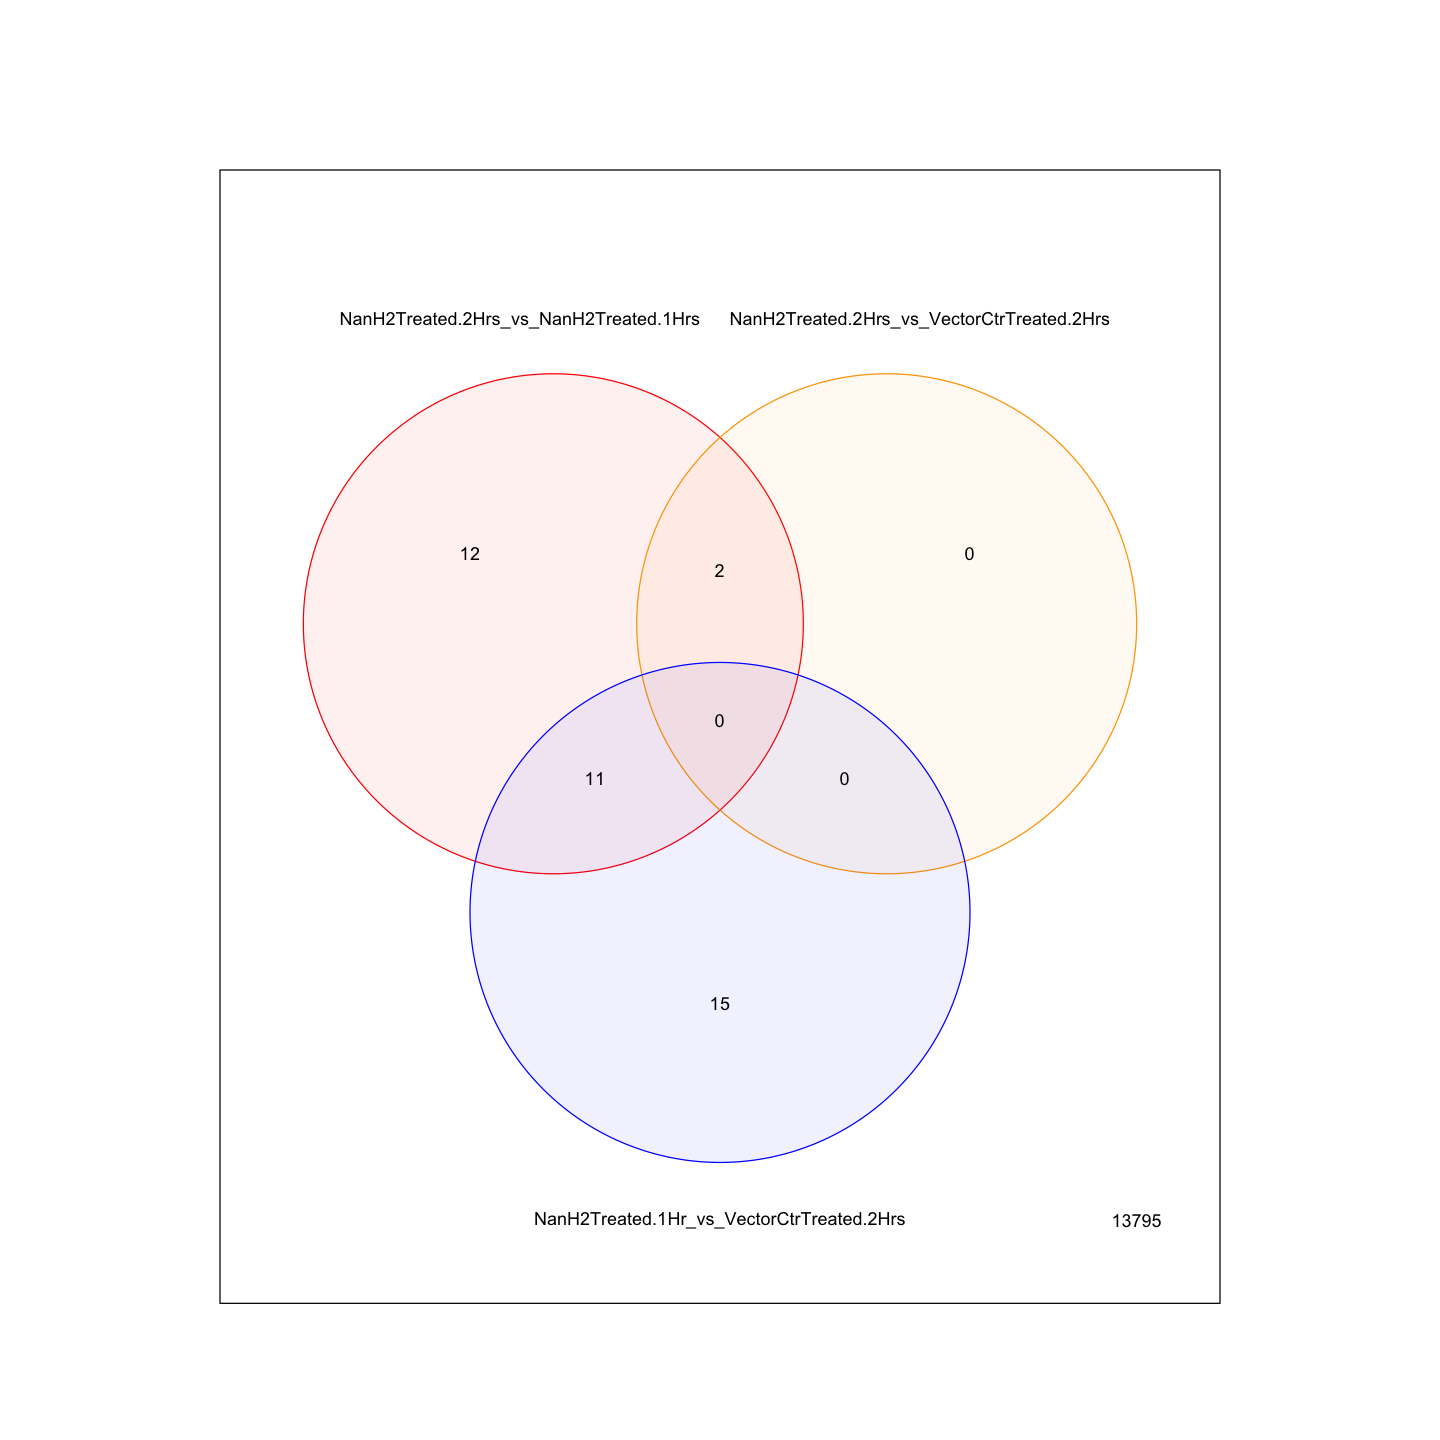

In [35]:
globalPlotAndSaveComparisonsVenn("All", 
                                c(1,2,3), c("red", "orange", "blue"), heightIn=12, widthIn=12)

The half of the NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs differentially expressed genes are also found to be differentially expressed in VectroCtrTreated.2Hrs_vs_NanH2Treated.1Hrs.


[Table of Contents](#Table-of-Contents)

### Examination of Individual Comparisons


In [36]:
gNumTopHitsShown = 20
gNumHeatmapGenes = 25

In [37]:
colnames(gNormedFilteredDgeList$samples)

[1] "group"                       "lib.size"                   
 [3] "norm.factors"                "Sample.Name"                
 [5] "Sample.Code"                 "Reference.Genome..Organism."
 [7] "Gender"                      "Condition"                  
 [9] "Time.point"                  "Condition_Time"

In [38]:
gGroupMetadataColName = "Condition_Time"

In [39]:
gGroupMetadataVector = as.character(gNormedFilteredDgeList$samples[[gGroupMetadataColName]])

In [40]:
unique(gGroupMetadataVector)

[1] "NanH2_treated_2H"  "NanH2_treated_1H"  "Vector_treated_2H"

In [41]:
CustomSortColumns <- c("Vector_treated_2H", 'NanH2_treated_1H','NanH2_treated_2H')
# CustomSortColumns <- FALSE

Perform each of the requested comparisons individually and produce output gene lists and visualizations.  Each comparison produces the following information:

* A power analysis showing the power to detect various fold-changes given the size of the first and second groups in the comparison.
* A summary of the number of up- and down-regulated genes meeting the adjusted p-value threshold as described above.  Up-regulated genes are those that are more highly expressed in the first group listed in the comparison name than in the second--genes up-regulated in a comparison named, say, Day15vsDay0 are those that are more highly expressed in Day 15 than in Day 0.  The analogous description applies to down-regulated genes.
* A table of the top 20 most differentially expressed genes in the comparison, as determined by adjusted p-value, without regard to the direction of their fold change.  They are sorted by increasing adjusted p-value. Note that this list always shows the top 20 most differentially expressed genes, even if those genes are not statistically significant according to the threshold listed above.   
* A comma-separated-value (csv) file containing the differential expression results (log fold change, adjusted p-value, etc) for **EVERY** gene, regardless of whether it is found to be significantly differentially expressed.  Like the table, it is sorted by increasing adjusted p-value, but is suitable for import into a spreadsheet program for re-sorting or filtering (for example, by log fold-change).  Having a list of all genes enables checking the results for genes that are of interest but were NOT found to be significant. 
* A mean-difference plot (also known as an MA plot) showing the log fold change of each gene in the comparison as a function of its average log expression.  Genes that are up-regulated in the comparison are shown in yellow, those that are down-regulated are shown in blue, and those that are not statistically significantly regulated at the threshold listed above are shown in black.
* A heat map of the expression, across all samples, of the top 100 significantly differentially expressed genes (those meeting the adjusted p-value threshold as described above) in this particular comparison.  
* An interactive mean-difference plot produced by the Glimma package ([16](#Citations)). Glimma plots can be found in the glimma-plots directory. Genes can be filtered by various statistics (i.e. adjusted P value, average expression, log-fold change, etc) and logCPM levels of individual samples can be examined for each gene.

In [42]:
library(RNASeqPower)

getNumSamplesInGroup = function(coefficientNumber, contrastMatrix, designMatrix, 
                                contrastValue=1){
    contrastDf = as.data.frame(contrastMatrix)
    coefficientName = colnames(contrastDf)[coefficientNumber]

    if (dim(contrastDf)[2]==1){ #for experiments with only 1 comparison
        groupName = row.names(contrastDf)[which(contrastDf[[coefficientName]] == contrastValue)]
    }else{
        groupName = row.names(contrastDf[which(contrastDf[[coefficientName]] == contrastValue),])
    }
        
    designModelDf = as.data.frame(designMatrix)
    groupSize = lapply(designModelDf[groupName], sum)
    return(as.vector(unlist(groupSize)))
    
}

doPowerCalculation = function(coefficientNumber, contrastMatrix, designMatrix, 
                              coverage, bcv, effect, targetAlpha){
    numSamplesGroup1 = getNumSamplesInGroup(coefficientNumber, contrastMatrix, 
                                            designMatrix, 1)
    numSamplesGroup2 = getNumSamplesInGroup(coefficientNumber, contrastMatrix, 
                                            designMatrix, -1)
    sizePerGroup = c(numSamplesGroup1, numSamplesGroup2)        

    # Find the power for a study with sizePerGroup (can be a vector) per group, 
    # to detect an (effect) change, given coverage?
    rnapower(coverage, cv=bcv, effect=c(1.25, 1.5, 1.75, 2), n=sizePerGroup, 
             alpha=targetAlpha)    
}

In [43]:
globalDoPowerCalculation = function(coefficientNumber, coverage=10,
                                    effect=c(1.25, 1.5, 1.75, 2), 
                                    targetAlpha=0.05){
    display('Power calculation: x is fold-change, y is group size')
    doPowerCalculation(coefficientNumber, gContrastMatrix, gDesignModel, 
                              coverage, gBcv, effect, targetAlpha)
}

In [44]:
#single gene heatmap
plotSingleGeneHeatmap=function(gene, subGroups){
    index <- which(gVoomResult$genes$SYMBOL==gene)
    single_gene_df <- as.data.frame(gVoomResult$E[index,subGroups])
    single_gene_df$Names <- row.names(single_gene_df)
    colnames(single_gene_df) <- c("Values", "sample")
    #merge/add "day" col
    single_gene_df<- merge(single_gene_df, gVoomResult$targets, by="sample" )

    #remove unnecessary cols
    single_gene_df <- subset(single_gene_df, select = -c(lib.size, norm.factors, replicate))

    p <- ggplot(single_gene_df, aes(x = sample, y="", fill = Values)) + 
        #heatmap style (tiles)
        geom_tile(colour="white", 
                  width=1) +
        #heatmap colors
        scale_fill_gradient(low = "blue",  
                            high = "red")+  
        #x & y axis labels
        labs(x="",
             y=gene)  + 
       #group columns
        facet_wrap(~day, 
                   nrow = 1, 
                   scales="free_x",
                  strip.position = "top") +
        #group columns' box color and spacing
        theme(legend.position="none",
            panel.border = element_blank(), 
            strip.background = element_rect(colour="black",
                                            fill="white"),
           panel.spacing.x = unit(0,"line"))+ #remove gaps between tiles

        scale_x_discrete(expand=c(0,0)) +
        scale_y_discrete(expand=c(0,0)) +
        theme(aspect.ratio = 1) 

        #x label
    p <- p + theme(axis.text.x = element_text(angle = 90,
                                              vjust = 0.5, 
                                              hjust=1)) 

    return(p)
}

In [45]:
library(gplots)

composeFileNameForCoefficient = function(aFit, outputDir, extension, runName, description, coeffNumber){
    coeffName = colnames(aFit)[coeffNumber]
    fileName = paste(runName, coeffName, description, sep = "_")
    fileName = paste0(fileName, extension)
    return(fileName)
}

composeFileNameForHeatmap = function(aFit, outputDir, extension, runName, description, coeffNumber, expGroups){
    coeffName = colnames(aFit)[coeffNumber]
    groupsName = paste(expGroups, sep = "_", collapse = "_")
    fileName = paste(runName, coeffName, description, groupsName, sep = "_")
    fileName = paste0(fileName, extension)
    return(fileName)
}

outputTopHitsForCoefficient = function(aFit, outputDir, runName, description, coeffNumber){
    topHits = topTreat(aFit, n=Inf, coef=coeffNumber)
    fileName = composeFileNameForCoefficient(aFit, outputDir, ".csv", runName, description, coeffNumber)
    write.csv(topHits, file.path(outputDir, fileName), row.names=FALSE)
    print(paste0("Output file: ", fileName))
    return(topHits)
}


getSortedSubGroups = function(sorted_list, gGroupMetadataVector){
    sortedGroups <- c()
    for (i in sorted_list){
        x <- which(gGroupMetadataVector == i )
        sortedGroups<- c(sortedGroups, x)
    }
    return(sortedGroups)
}


plotMdForCoefficient = function(aFit, aTestResults, outputDir, runName, description, coeffNumber) {
    makeCustomMdPlot = function(){
        plotMD(aFit, column=coeffNumber, 
           status=aTestResults[,coeffNumber], 
           values=c(1, -1),
           main=colnames(aFit)[coeffNumber],
           hl.col=c("yellow","blue"), legend=FALSE)        
    }
    
    makeCustomMdPlot()
    
    fileName = composeFileNameForCoefficient(aFit, outputDir, ".png", 
                                             runName, description, coeffNumber)
    png(filename = file.path(outputDir, fileName), height = 7, width = 7, 
      units = "in", res = 300)
    
    makeCustomMdPlot()           
           
    dev.off()  
}

plotTopHeatmapForCoefficient = function(aFit, aVoomResults, numTopGenes, 
                                        outputDir, runName, metadataVector, description, 
                                        coeffNumber, geneNaId, expGroups){
    
    topHits = topTreat(aFit, coef=coeffNumber, number=numTopGenes, p.value=0.05)
    i = which(aVoomResults$genes[[geneNaId]] %in% topHits[[geneNaId]])
    mycol = colorpanel(1000, "blue", "white", "red")

    if (tolower(expGroups) == "all") {
        if (CustomSortColumns == FALSE) {
            subGroups <- which(metadataVector %in% metadataVector)
            colv <- TRUE
        }
        else{
            subGroups <- getSortedSubGroups(CustomSortColumns, metadataVector)
            colv <- FALSE
        }
    } else {
        subGroups <- getSortedSubGroups(expGroups, metadataVector)
        colv <- FALSE
    }
    group_col = brewer.pal(12, "Set3")[as.factor(metadataVector[subGroups])]
    geneNames <- aVoomResults$genes$SYMBOL[i]
    symbolNaIdx <- which(is.na(aVoomResults$genes$SYMBOL[i]))
    geneNames[symbolNaIdx] <- aVoomResults$genes[[geneNaId]][symbolNaIdx]
    
    makeCustomHeatmap = function(){
        heatmap.2(aVoomResults$E[i,subGroups], 
                  scale="row", 
                  labRow=geneNames, 
                  labCol=aVoomResults$targets$Filename[subGroups], # May need to change to represent variable containing sample name
                  ColSideColors=group_col,
                  col=mycol, 
                  trace="none", 
                  density.info="none", 
                  Colv=colv,
                  cexRow=2,
                  hclustfun = function(d) hclust(d, method = 'average'), 
                  dendrogram='row',
                 margin=c(15,15), lhei=c(2,10))  
        legend("topleft", fill=unique(group_col), legend=unique(metadataVector[subGroups]), 
               inset=c(0,0.1), cex=0.7)
    }

    
    if (length(geneNames)==1){
        plotSingleGeneHeatmap(geneNames, subGroups)
    }else{
        makeCustomHeatmap()
        fileName = composeFileNameForHeatmap(aFit, outputDir, ".png", runName, description, coeffNumber, expGroups)
        png(filename = file.path(outputDir, fileName), height = 12, width = 7, 
          units = "in", res = 300)   
        makeCustomHeatmap()
        dev.off() 
    }
          
   
}
    


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [46]:
gAllGenesDesc = "AllGenes"
gMaDesc = paste("MaPlot", gThresholdDescription, sep="_")
gHeatmapDesc = paste(paste0("Heatmap","Top",gNumHeatmapGenes), gThresholdDescription, sep="_")

globalSummarizeTestsAndPlotMdForCoefficient = function(coefficientNumber){
    display(globalDoPowerCalculation(coefficientNumber))
    coefficientName = colnames(gModeratedVoomedFitForContrastsWithLogFcThreshold)[coefficientNumber]
    deliverablesPath = paste0(gOutputDir_nb3, "/", coefficientName)
    dir.create(deliverablesPath)
    display(paste("Summary of", coefficientName, "Differential Expression"))
    display(summary(decideTests(gModeratedVoomedFitForContrastsWithLogFcThreshold, method=gMultipleTestingStrategy))[,coefficientNumber])    

    display(paste("Top", gNumTopHitsShown, "Most Significantly Differentially Expressed Genes for", coefficientName))
    display(head(n=gNumTopHitsShown,
        outputTopHitsForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold,
                                    deliverablesPath, gRunName, gAllGenesDesc, coefficientNumber)))    

    options(repr.plot.width=7, repr.plot.height=7)
    
    plotMdForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
                         gLogThresholdedTestResults, deliverablesPath, 
                         gRunName, gMaDesc, coefficientNumber) 
    
    aGlimmaPlotName = composeFileNameForCoefficient(
        gModeratedVoomedFitForContrastsWithLogFcThreshold, 
        gOutputDir_nb3, "_interactive", gRunName, gMaDesc, coefficientNumber)
    
    
    glMDPlot(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
         coef = coefficientNumber, 
         status = decideTests(gModeratedVoomedFitForContrastsWithLogFcThreshold), 
         main = colnames(gContrastMatrix)[coefficientNumber], 
         side.main = "ENSEMBLID",
         counts = gVoomResult$E, 
         groups = as.factor(gGroupMetadataVector), 
         side.ylab = "logCPM", 
         path = gOutputDir_nb3,
         html = aGlimmaPlotName, launch = F)
    
    
    print(paste0("Output file: ", paste0("glimma-plots/", aGlimmaPlotName, ".html")))    
}

globalPlotTopHeatmapForCoefficient = function(coefficientNumber, expGroups){
    options(repr.plot.width=7, repr.plot.height=12)  
    
    coefficientName = colnames(gModeratedVoomedFitForContrastsWithLogFcThreshold)[coefficientNumber]
    display(paste("Heatmap of Top", gNumHeatmapGenes, "Most Significantly Differentially Expressed Genes for", coefficientName))
    plotTopHeatmapForCoefficient(gModeratedVoomedFitForContrastsWithLogFcThreshold, 
                                 gVoomResult, gNumHeatmapGenes, 
                                 paste0(gOutputDir_nb3, "/", colnames(gModeratedVoomedFitForContrastsWithLogFcThreshold)[coefficientNumber]), 
                                 gRunName, gGroupMetadataVector, gHeatmapDesc, 
                                 coefficientNumber, gGeneIdCol, expGroups)  
}

In [61]:
library(ggrepel)
options(warn = -1)
plotVolcanoPlot=function(coefficientNumber){
    DE_genes = topTreat(gModeratedVoomedFitForContrastsWithLogFcThreshold, coef=coefficientNumber, number = Inf)
    DE_genes$genes <- DE_genes$SYMBOL
    # The significantly differentially expressed genes are the ones found in the upper-left and upper-right corners.
    # Add a column to the data frame to specify if they are UP- or DOWN- regulated (log2FoldChange respectively positive or negative)

    # add a column of NAs
    DE_genes$diffexpressed <- "NO"
    # if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
    DE_genes$diffexpressed[DE_genes$logFC > 0 & DE_genes$adj.P.Val < 0.05] <- "UP"
    # if log2Foldchange < -0.6 and pvalue < 0.05, set as "DOWN"
    DE_genes$diffexpressed[DE_genes$logFC < 0 & DE_genes$adj.P.Val < 0.05] <- "DOWN"

    # Create a new column "delabel" to de, that will contain the name of genes differentially expressed (NA in case they are not)
    DE_genes$delabel <- NA
    DE_genes$delabel[DE_genes$diffexpressed != "NO"] <- DE_genes$genes[DE_genes$diffexpressed != "NO"]

    ggplot(data=DE_genes, aes(x=logFC, y=-log10(adj.P.Val), col=diffexpressed, label=delabel)) +
                    geom_point() + 
                    theme_minimal() +
                    geom_text_repel() +
                    scale_color_manual(values=c("blue", "black", "red")) +
                    geom_vline(xintercept=c(-1, 1), col="red") +
                    geom_hline(yintercept=-log10(0.05), col="red")
}

[Table of Contents](#Table-of-Contents) 

## NanH2 treated at 2 hrs vs NanH2 treated at 1 hr

[1] "Power calculation: x is fold-change, y is group size"

,1.25,1.5,1.75,2
4,0.1640213,0.4302281,0.6923479,0.8621645
4,0.1640213,0.4302281,0.6923479,0.8621645


[1] "Summary of NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs Differential Expression"

Down NotSig     Up 
    15  13810     10

[1] "Top 20 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs"

,ENSEMBL,ENTREZID,SYMBOL,gene_type,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000144136,ENSG00000144136,6574,SLC20A1,protein_coding,-0.3544198,8.952613,-12.454504,1.566123e-09,2.166731e-05
ENSG00000170385,ENSG00000170385,7779,SLC30A1,protein_coding,0.4068143,7.905788,10.892237,1.039096e-08,7.187947e-05
ENSG00000169715,ENSG00000169715,4493,MT1E,protein_coding,0.6851243,6.316796,9.461456,7.151408e-08,3.297991e-04
ENSG00000196611,ENSG00000196611,4312,MMP1,protein_coding,-0.5991365,5.152540,-8.706573,2.159032e-07,7.467553e-04
ENSG00000136826,ENSG00000136826,9314,KLF4,protein_coding,-0.4405573,5.948174,-8.444516,3.217649e-07,8.903234e-04
ENSG00000100906,ENSG00000100906,4792,NFKBIA,protein_coding,0.4379722,5.339579,7.860802,8.064972e-07,1.859648e-03
ENSG00000110925,ENSG00000110925,81566,CSRNP2,protein_coding,0.2858830,5.752348,7.090143,2.900844e-06,5.733311e-03
ENSG00000171940,ENSG00000171940,7764,ZNF217,protein_coding,-0.3065292,6.330684,-6.962920,3.610742e-06,6.244328e-03
ENSG00000120738,ENSG00000120738,1958,EGR1,protein_coding,-0.4724118,5.291931,-6.499125,8.171186e-06,1.187877e-02


[1] "Output file: 20230307084317_NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs_AllGenes.csv"
[1] "Output file: glimma-plots/20230307084317_NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs_MaPlot_DiffExpFdrLte0.05_interactive.html"


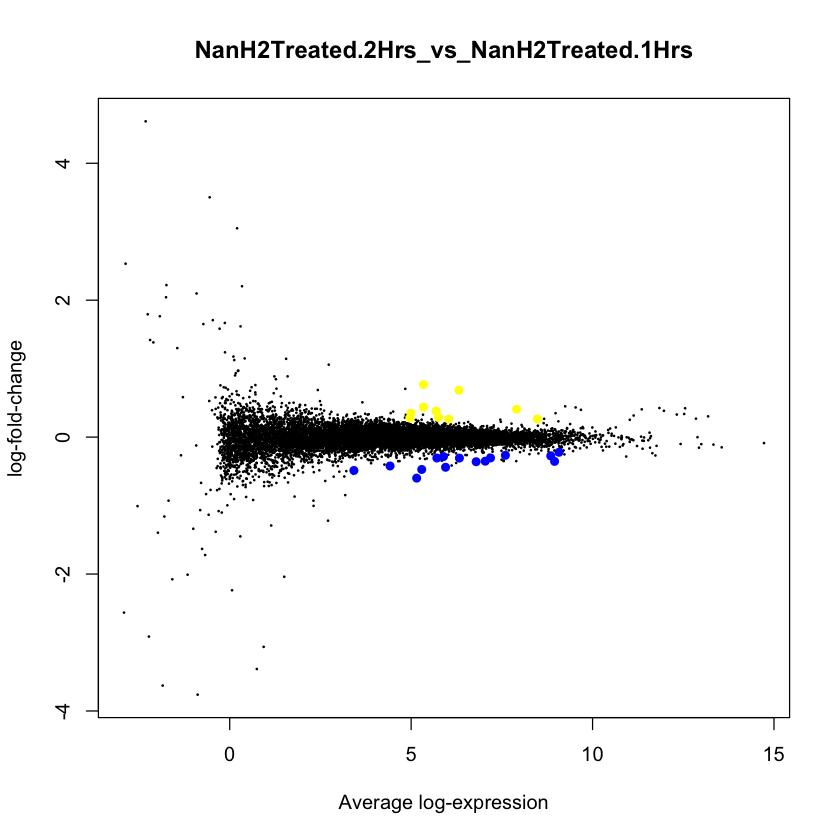

In [48]:
globalSummarizeTestsAndPlotMdForCoefficient(1)

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs"

pdf 
  2

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs"

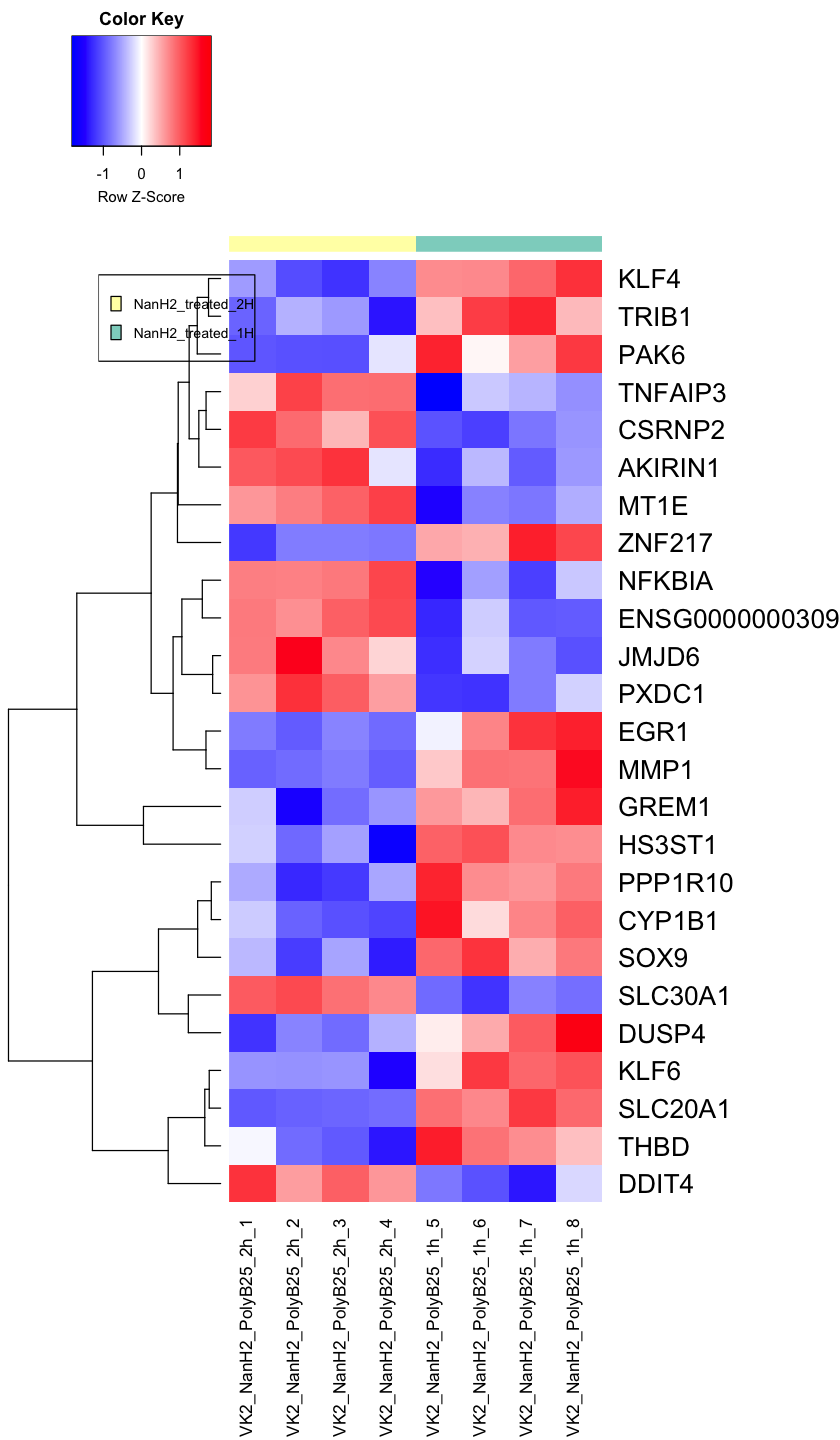

pdf 
  2

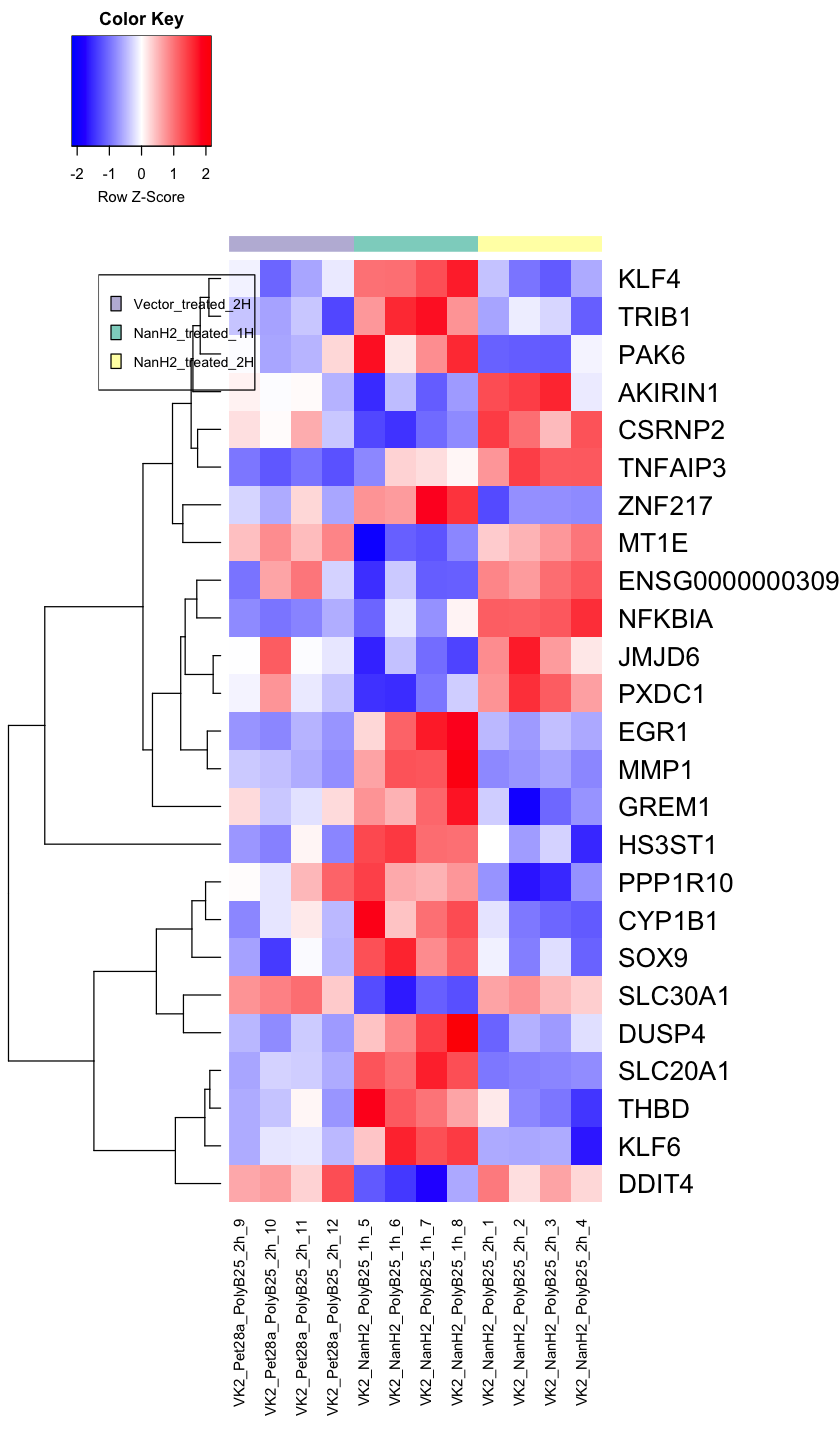

In [50]:
globalPlotTopHeatmapForCoefficient(1, c("NanH2_treated_2H","NanH2_treated_1H"))  

globalPlotTopHeatmapForCoefficient(1, "all")  

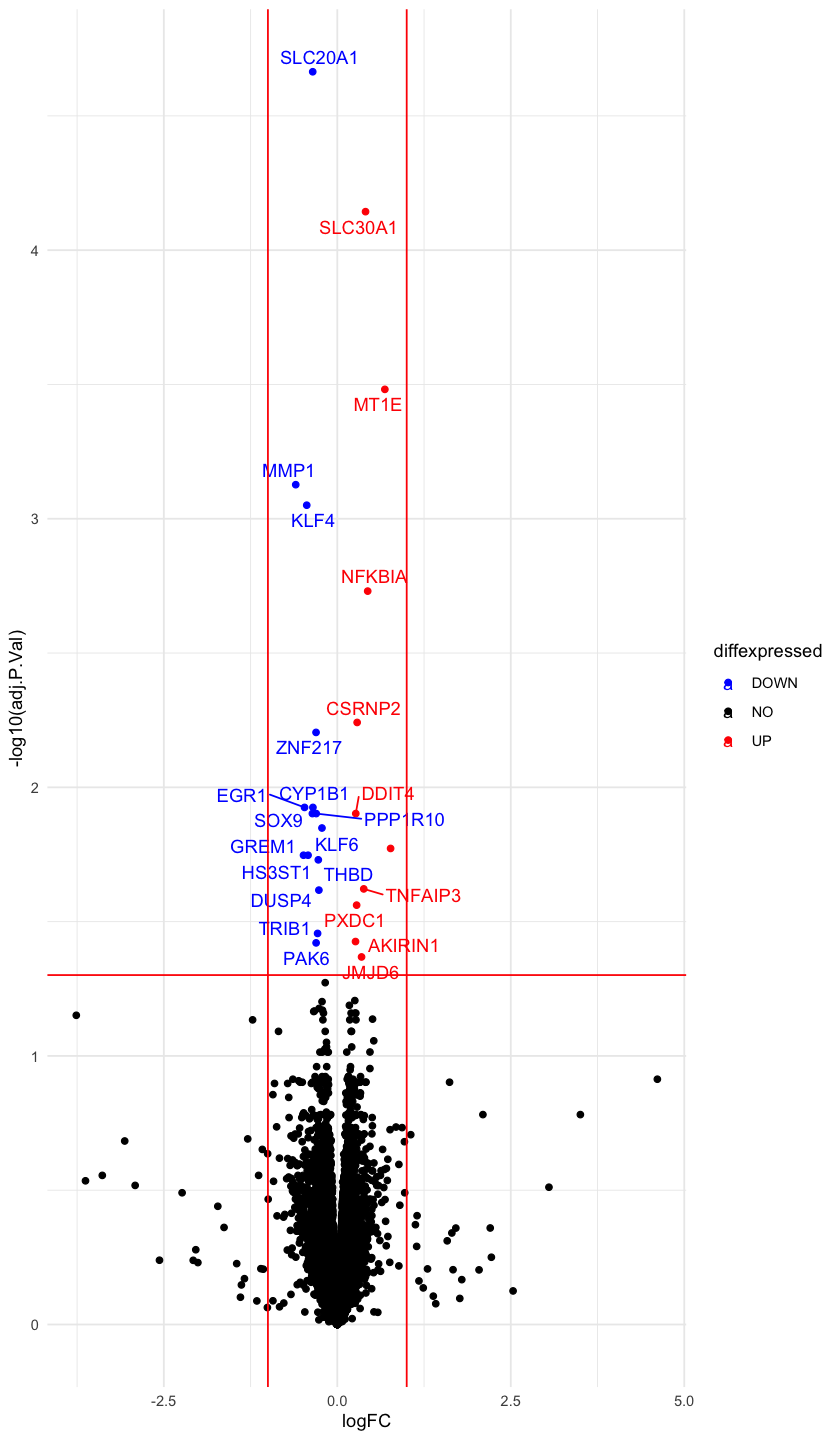

In [51]:
plotVolcanoPlot(1)

[Table of Contents](#Table-of-Contents) 

## NanH2 treated at 2 hrs vs Vector Ctrl treated at 1 hr

[1] "Power calculation: x is fold-change, y is group size"

,1.25,1.5,1.75,2
4,0.1640213,0.4302281,0.6923479,0.8621645
4,0.1640213,0.4302281,0.6923479,0.8621645


[1] "Summary of NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs Differential Expression"

Down NotSig     Up 
     0  13833      2

[1] "Top 20 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs"

,ENSEMBL,ENTREZID,SYMBOL,gene_type,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000118503,ENSG00000118503,7128,TNFAIP3,protein_coding,0.7025992,5.6896146,10.023990,3.268654e-08,0.0004522183
ENSG00000100906,ENSG00000100906,4792,NFKBIA,protein_coding,0.5170235,5.3395792,8.958177,1.483186e-07,0.0010259942
ENSG00000269897,ENSG00000269897,100532731,COMMD3-BMI1,protein_coding,-4.4544249,-0.8837475,-5.848501,2.700367e-05,0.1245319479
ENSG00000170949,ENSG00000170949,90338,ZNF160,protein_coding,-0.2317912,4.9659976,-5.138606,1.061425e-04,0.3652862321
ENSG00000179304,ENSG00000179304,727866,FAM156B,protein_coding,4.2343765,1.7294139,5.028423,1.320153e-04,0.3652862321
ENSG00000204569,ENSG00000204569,5514,PPP1R10,protein_coding,-0.2360875,7.1872710,-4.855862,1.863048e-04,0.4295878676
ENSG00000253293,ENSG00000253293,3206,HOXA10,protein_coding,0.5084822,2.1141904,4.773655,2.197860e-04,0.4343913714
ENSG00000101665,ENSG00000101665,4092,SMAD7,protein_coding,0.2426998,4.5454091,4.544079,3.499970e-04,0.5324304392
ENSG00000123689,ENSG00000123689,50486,G0S2,protein_coding,0.2428086,5.9497912,4.540360,3.526598e-04,0.5324304392


[1] "Output file: 20230307084317_NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs_AllGenes.csv"
[1] "Output file: glimma-plots/20230307084317_NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs_MaPlot_DiffExpFdrLte0.05_interactive.html"


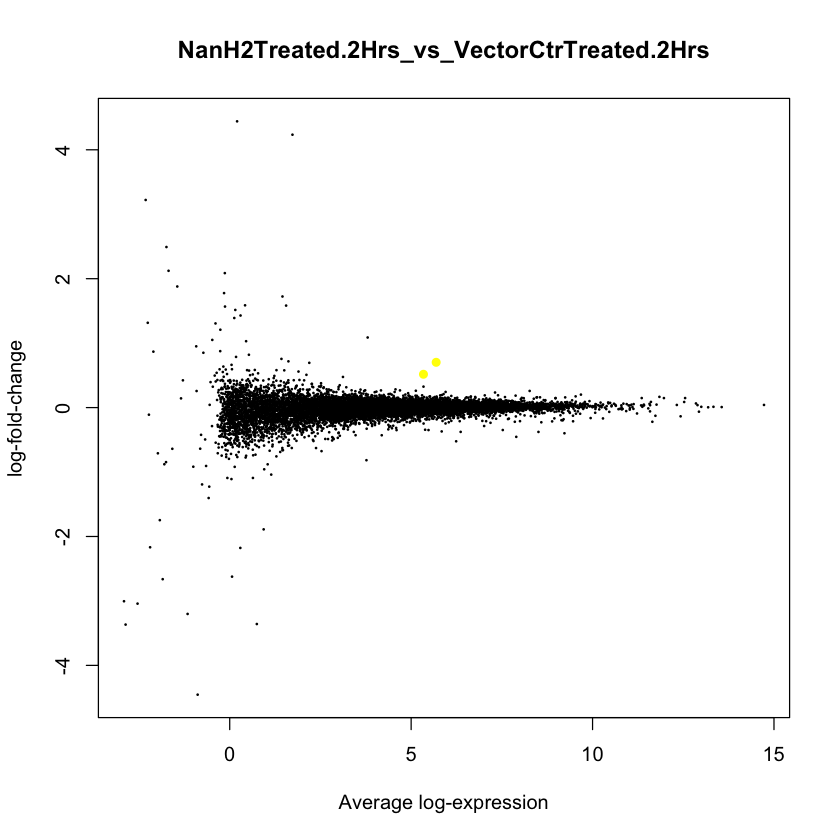

In [52]:
globalSummarizeTestsAndPlotMdForCoefficient(2)

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs"

pdf 
  2

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.2Hrs_vs_VectorCtrTreated.2Hrs"

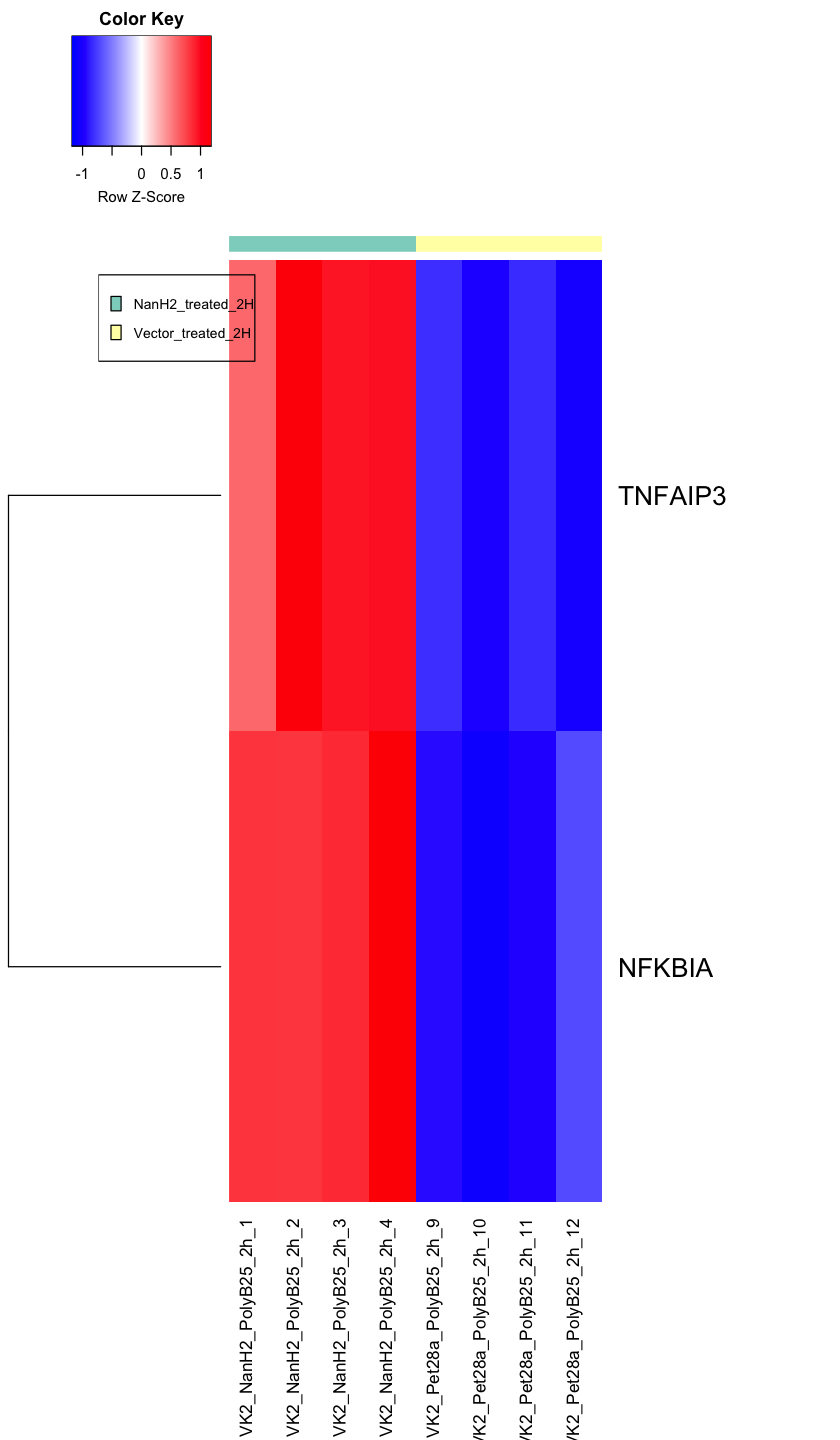

pdf 
  2

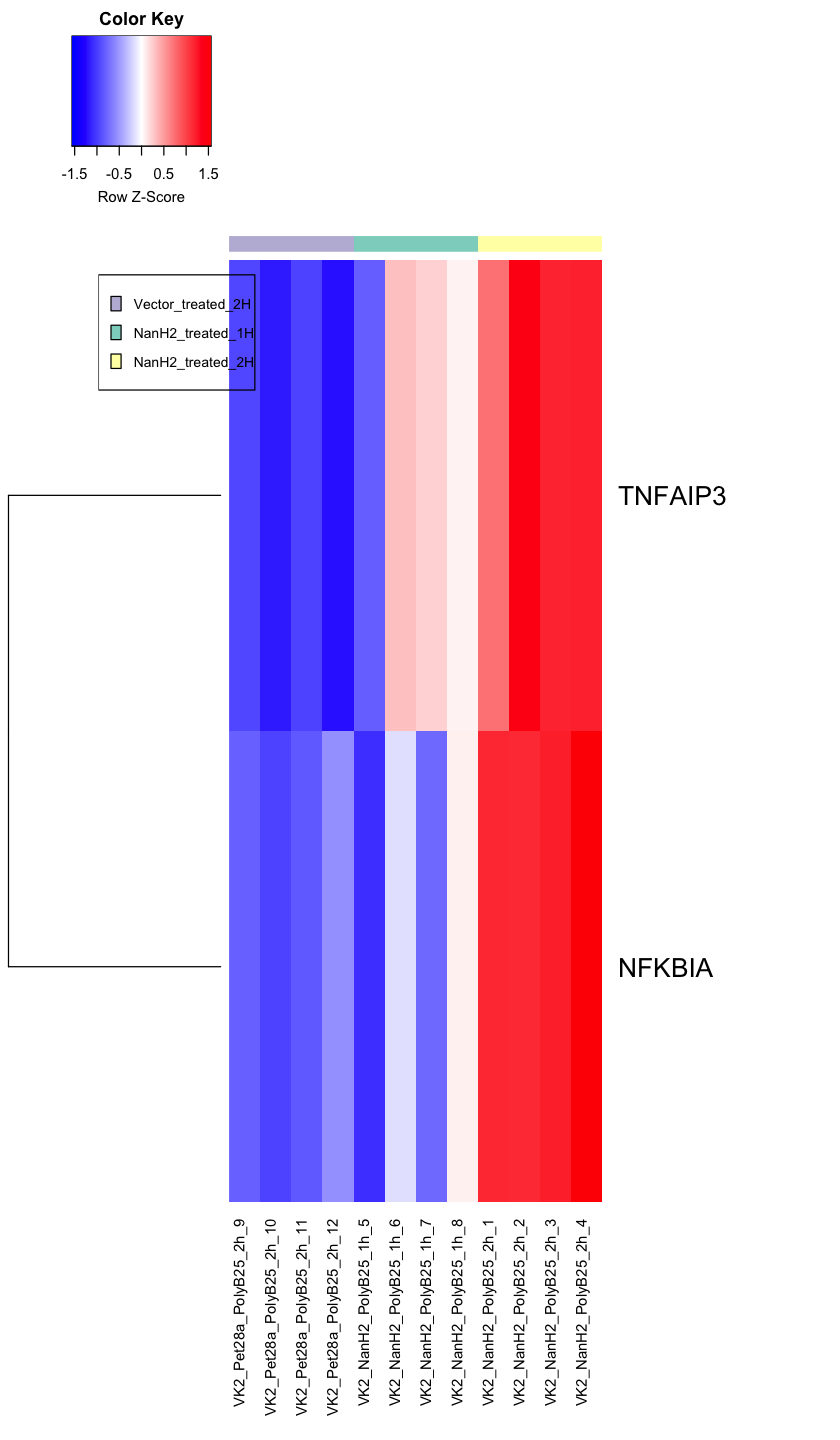

In [54]:
globalPlotTopHeatmapForCoefficient(2, c('NanH2_treated_2H','Vector_treated_2H'))
globalPlotTopHeatmapForCoefficient(2, "all")

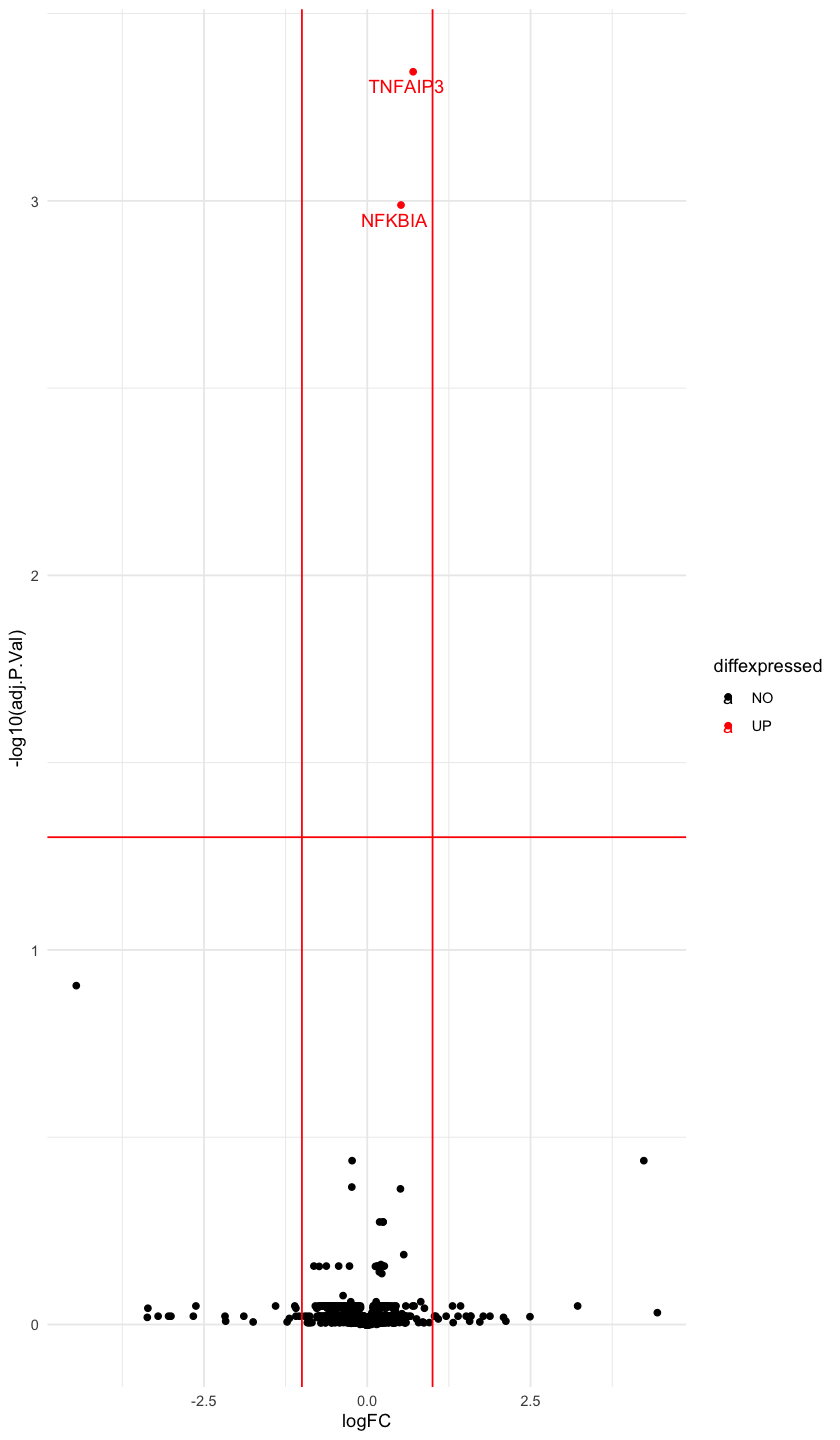

In [60]:
plotVolcanoPlot(2)

[Table of Contents](#Table-of-Contents) 

## Vector Ctrl treated at 2hrs vs NanH2 treated at 1 hr

[1] "Power calculation: x is fold-change, y is group size"

,1.25,1.5,1.75,2
4,0.1640213,0.4302281,0.6923479,0.8621645
4,0.1640213,0.4302281,0.6923479,0.8621645


[1] "Summary of NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs Differential Expression"

Down NotSig     Up 
     3  13809     23

[1] "Top 20 Most Significantly Differentially Expressed Genes for NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs"

,ENSEMBL,ENTREZID,SYMBOL,gene_type,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000170385,ENSG00000170385,7779,SLC30A1,protein_coding,-0.4510892,7.905788,-12.081064,2.417315e-09,3.344355e-05
ENSG00000144136,ENSG00000144136,6574,SLC20A1,protein_coding,0.2881103,8.952613,10.132228,2.822120e-08,1.952201e-04
ENSG00000169715,ENSG00000169715,4493,MT1E,protein_coding,-0.6861847,6.316796,-9.461147,7.154544e-08,3.299437e-04
ENSG00000196611,ENSG00000196611,4312,MMP1,protein_coding,0.5361829,5.152540,7.816400,8.664020e-07,2.996668e-03
ENSG00000136826,ENSG00000136826,9314,KLF4,protein_coding,0.3741043,5.948174,7.188723,2.451936e-06,6.784506e-03
ENSG00000168209,ENSG00000168209,54541,DDIT4,protein_coding,-0.2974221,8.476403,-7.041466,3.153463e-06,7.240711e-03
ENSG00000120738,ENSG00000120738,1958,EGR1,protein_coding,0.5104490,5.291931,6.954529,3.663533e-06,7.240711e-03
ENSG00000125398,ENSG00000125398,6662,SOX9,protein_coding,0.3694529,6.791815,6.499038,8.172452e-06,1.413323e-02
ENSG00000124882,ENSG00000124882,2069,EREG,protein_coding,0.3687732,6.771328,6.374456,1.022842e-05,1.572336e-02


[1] "Output file: 20230307084317_NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs_AllGenes.csv"
[1] "Output file: glimma-plots/20230307084317_NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs_MaPlot_DiffExpFdrLte0.05_interactive.html"


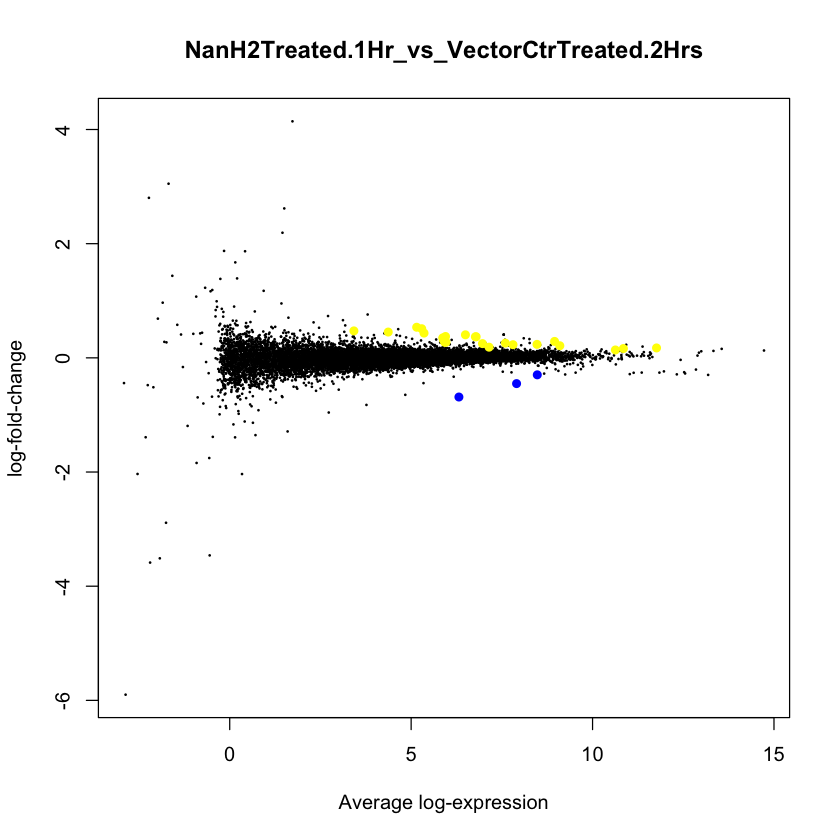

In [62]:
globalSummarizeTestsAndPlotMdForCoefficient(3)

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs"

pdf 
  2

[1] "Heatmap of Top 25 Most Significantly Differentially Expressed Genes for NanH2Treated.1Hr_vs_VectorCtrTreated.2Hrs"

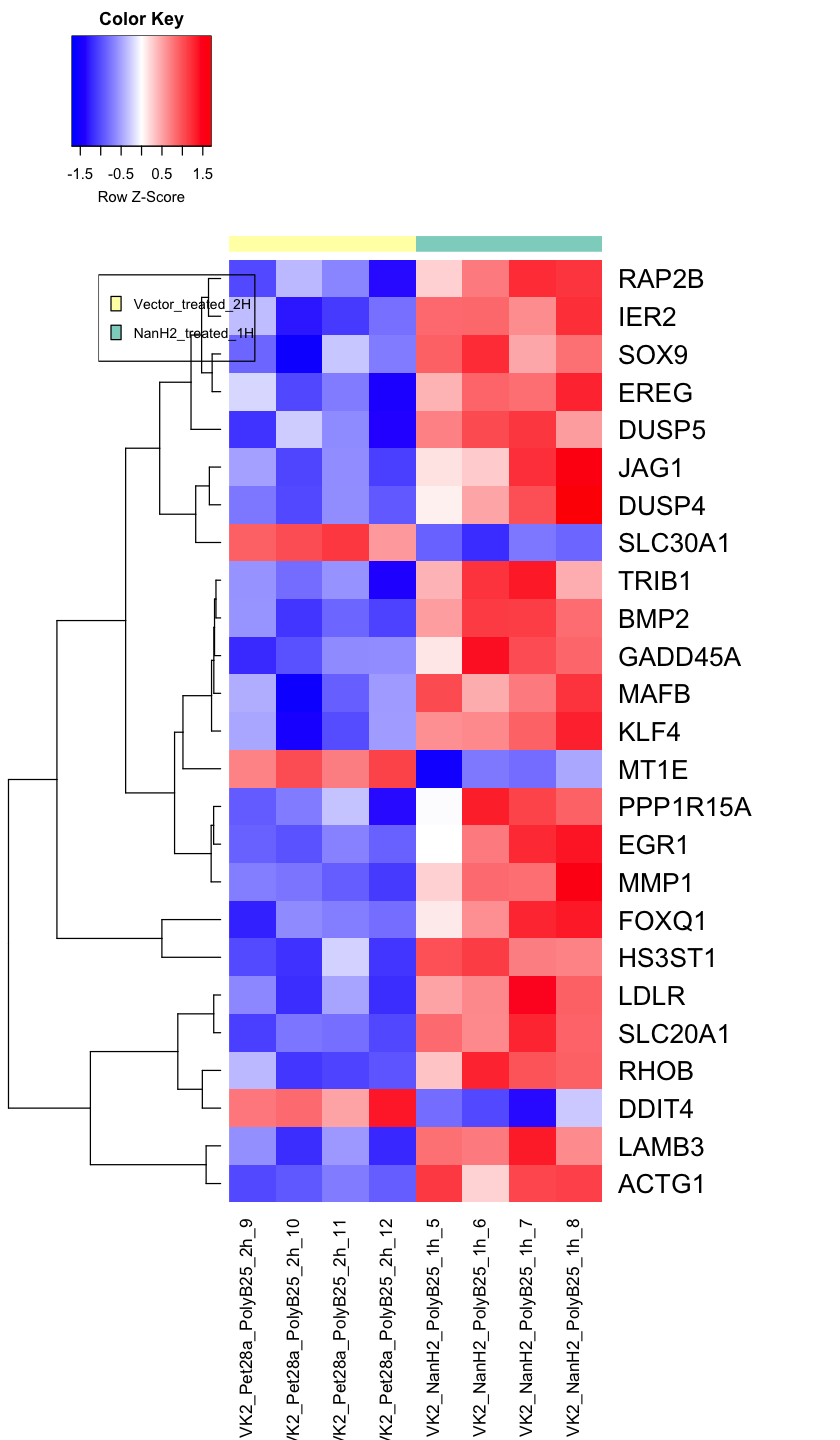

pdf 
  2

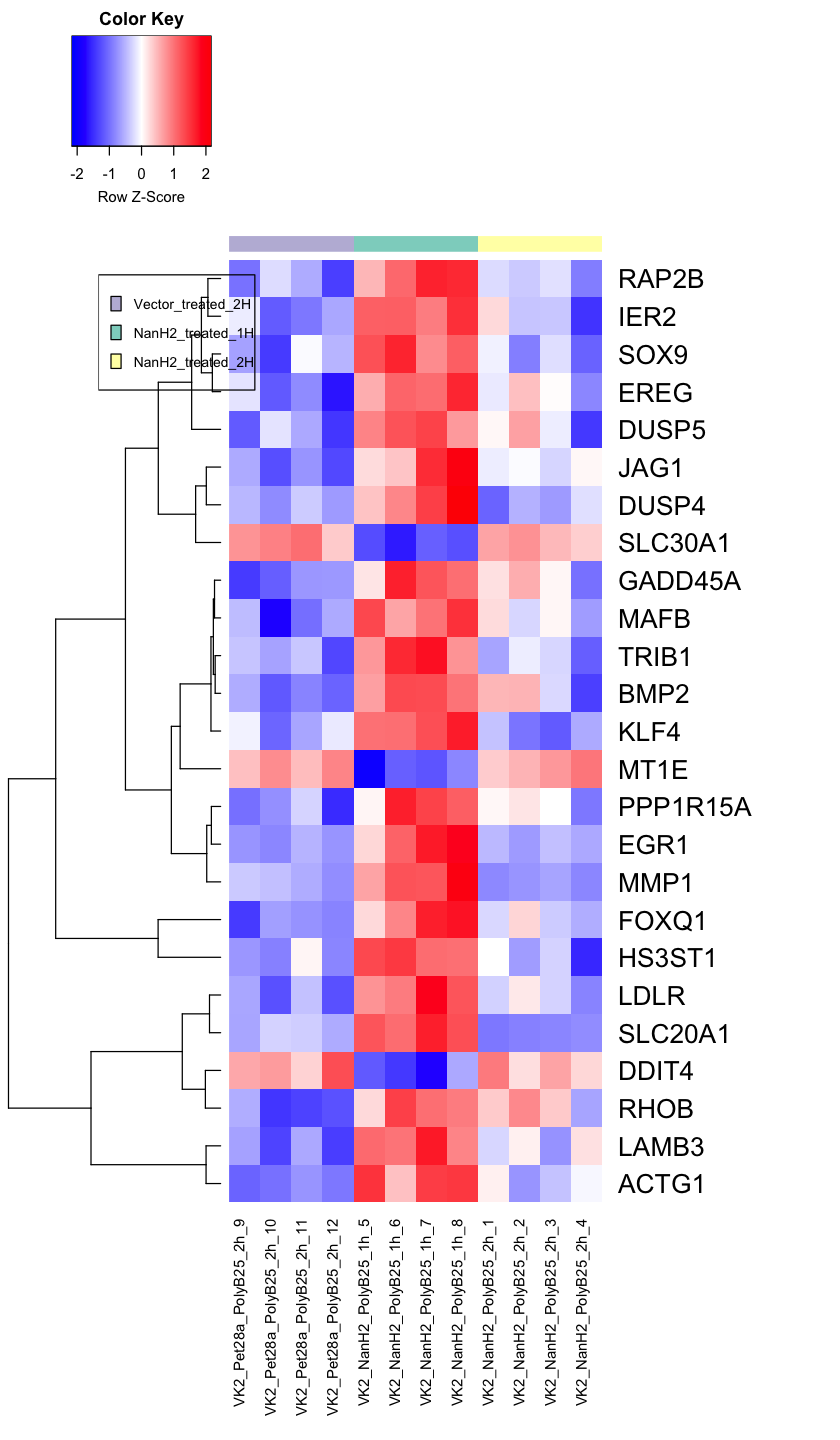

In [63]:
globalPlotTopHeatmapForCoefficient(3, c("Vector_treated_2H",'NanH2_treated_1H'))
globalPlotTopHeatmapForCoefficient(3,'all')

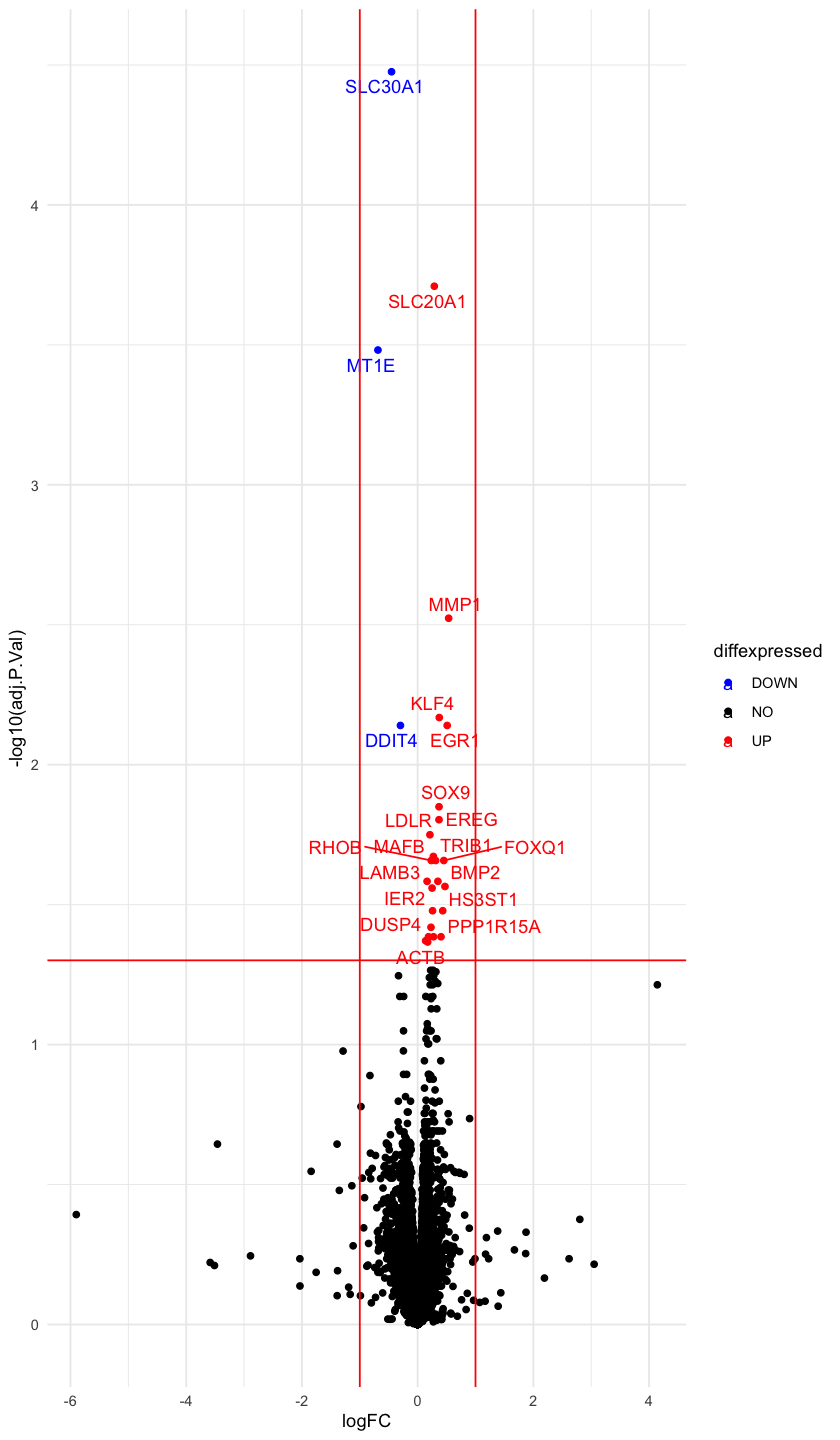

In [64]:
plotVolcanoPlot(3)

[Table of Contents](#Table-of-Contents)

Save the workspace objects for future reference:


In [65]:
writeWorkspaceImage(gInterimDir, paste0(gRunName,"_differential_expression"))

[1] "Output file: 20230307084317_differential_expression.RData"


[Table of Contents](#Table-of-Contents)

## Summary

* We found a few significant differentially expressed (Pval<0.05) in all 3 comparisons.

* The half of the NanH2Treated.2Hrs_vs_NanH2Treated.1Hrs differentially expressed genes are also found to be differentially expressed in VectroCtrTreated.2Hrs_vs_NanH2Treated.1Hrs.

[Table of Contents](#Table-of-Contents)

## Citations



1. Law CW, Alhamdoosh M, Su S, Smyth GK, Ritchie ME. RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR. Version 2. F1000Res. 2016 Jun 17 [revised 2016 Jan 1];5:1408.
2. Ritchie, ME, Phipson, B, Wu, D, Hu, Y, Law, CW, Shi, W, and Smyth, GK (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Research 43(7), e47.
3. Robinson MD, McCarthy DJ and Smyth GK (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics 26, 139-140.
4. Huber W, Carey VJ, Gentleman R, Anders S, Carlson M, Carvalho BS, Bravo HC, Davis S, Gatto L, Girke T, Gottardo R, Hahne F, Hansen KD, Irizarry RA, Lawrence M, Love MI, MacDonald J, Obenchain V, Oleś AK, Pagès H, Reyes A, Shannon P, Smyth GK, Tenenbaum D, Waldron L, Morgan M. Orchestrating high-throughput genomic analysis with Bioconductor. Nat Methods. 2015 Feb;12(2):115-21.
5. R Core Team (2016). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
6. Law CW, Chen Y, Shi W, Smyth GK. voom: Precision weights unlock linear model analysis tools for RNA-seq read counts. Genome Biol. 2014 Feb 3;15(2):R29.
7. https://www.machinelearningplus.com/machine-learning/complete-introduction-linear-regression-r/
8. Smyth, G. K., Ritchie, M., & Thorne, N. (2015). Linear Models for Microarray and RNA-Seq Data User’s Guide. R, (March 2016). https://www.bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf .
9. http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html
10. https://stat.ethz.ch/pipermail/bioconductor/2014-May/059713.html 
11. https://stat.ethz.ch/pipermail/bioconductor/attachments/20130530/4dcc9475/attachment.pl
12. Hart S, Therneau TM, Zhang Y, Poland GA, Kocher J-P. (2013). Calculating Sample Size Estimates for RNA Sequencing Data. Journal of Computational Biology, 20(12), 970-978.
13. Benjamini, Y. and Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. Journal of the Royal Statistical Society Series B 57, 289–300.
14. McCarthy DJ, Smyth GK. Testing significance relative to a fold-change threshold is a TREAT. Bioinformatics. 2009 Mar 15;25(6):765-71.
15. http://web.mit.edu/~r/current/arch/i386_linux26/lib/R/library/limma/html/ebayes.html
16. Su S, Law CW, Ah-Cann C, Asselin-Labat M, Blewitt ME, Ritchie ME (2017). Glimma: interactive graphics for gene expression analysis. Bioinformatics, 33(13), 2050-2052.

In [88]:
system("ipython nbconvert --to html *.ipynb")

[Table of Contents](#Table-of-Contents)

## Appendix: R Session Info

In [87]:
Sys.time()
sessionInfo()

[1] "2023-03-03 13:05:02 MST"

R version 4.1.3 (2022-03-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur/Monterey 10.16

Matrix products: default
BLAS/LAPACK: /Users/dchilinfuentes/opt/anaconda3/envs/RNAseq_env/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.1      gplots_3.1.3       RNASeqPower_1.34.0 ggplot2_3.3.6     
 [5] cowplot_1.1.1      RColorBrewer_1.1-3 IRdisplay_1.1      statmod_1.4.37    
 [9] Glimma_2.4.0       edgeR_3.36.0       limma_3.50.3      

loaded via a namespace (and not attached):
  [1] bitops_1.0-7                matrixStats_0.62.0         
  [3] bit64_4.0.5                 filelock_1.0.2             
  [5] progress_1.2.2              httr_1.4.3                 
  [7] GenomeInfoDb_1.30.1         repr_1.1.4                 
  [9] tools_4.1.3             

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham